In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from himodule.custom_classes import NasaDataset, WindowedLoader, AEConstructor, SimpleAE
from himodule.normalisation import StandardScaler, MinMaxScaler
from himodule.secondary_funcs import load_object, check_path, seed_everything

from collections import defaultdict

import os

sns.set_theme(style='whitegrid', font_scale=1.2)

In [2]:
# Check for GPU availability

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [3]:
seed = 37
batch_size = 20
window_size = 5

# Test dataset loading
test_dataset = NasaDataset('../datasets/clean_test_data.csv')

scaler_path = '../scalers/MinMaxScaler.pkl'
scaler = load_object('../scalers/MinMaxScaler.pkl')
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'

test_dataset.to(device)
test_dataset.dataset = scaler.transform(test_dataset.dataset)

### Simple AE

In [4]:
models_path = '../Models/norm-anom/'
layers_sizes = (8, 4, 2)

simple_model = SimpleAE(test_dataset.get_input_shape(), layers_sizes=layers_sizes)
simple_model.load_state_dict(torch.load(os.path.join(models_path, f'{layers_sizes}.pth')))
simple_model = simple_model.to(device)
loss_func = nn.MSELoss(reduction='none')

In [5]:
seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)
simple_test_loader = DataLoader(test_dataset, batch_size=batch_size, generator=g, shuffle=False)

In [6]:
simple_losses = list()

with torch.no_grad():
    for dta in simple_test_loader:
        sample = dta['sensors']
        _, reconstruction = simple_model(sample)
        loss = loss_func(reconstruction, sample)
        simple_losses.append(loss.mean(dim=1))
    
simple_losses = torch.hstack(simple_losses)

### Window AE

In [7]:
input_shape = test_dataset.get_input_shape()
layers_sizes = (input_shape*window_size//2, input_shape*window_size//4, input_shape*window_size//8)
models_path = f'../Models/window/{len(layers_sizes)+1}'

window_model = AEConstructor(input_shape, window_size=window_size, layers_sizes=layers_sizes)
window_model.load_state_dict(torch.load(os.path.join(models_path, f'{layers_sizes}.pth')))
window_model = window_model.to(device)
loss_func = nn.MSELoss(reduction='none')

window_test_loader = WindowedLoader(test_dataset, batch_size=batch_size, window_size=window_size)

In [9]:
window_losses_dct = defaultdict(list)

with torch.no_grad():
    for dta in window_test_loader:
        sample = dta['sensors']
        indeces = dta['indeces'].flatten()
        _, reconstruction = window_model(sample)
        loss = loss_func(nn.Flatten()(reconstruction), nn.Flatten()(sample))
        loss = loss.view(-1, window_size, input_shape).mean(dim=2).flatten()

        for idx, ls in zip(indeces, loss):
            window_losses_dct[idx.item()].append(ls.item())
        
window_losses = list()

for id, lst in window_losses_dct.items():
    window_losses.append(mean(lst))

## Plots

In [49]:
def make_plot(df: pd.DataFrame, machine_id: int, save_path: str = None):
    plt.close()
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)

    sns.lineplot(data=df,
                 x=df.index,
                 y='value',
                 hue='variable',
                 ax=ax)
    
    ax.set_ylabel('MSE')
    ax.set_xlabel(None)
    ax.set_title(f'Machine id: {machine_id}')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)

In [50]:
total_plot_df = pd.DataFrame((test_dataset.machine_ids.cpu().numpy(), simple_losses.cpu().numpy(), window_losses),
                             index=('machine_id', 'simple_model', 'window_model')).T
total_plot_df['machine_id'] = total_plot_df['machine_id'].astype(np.int16)

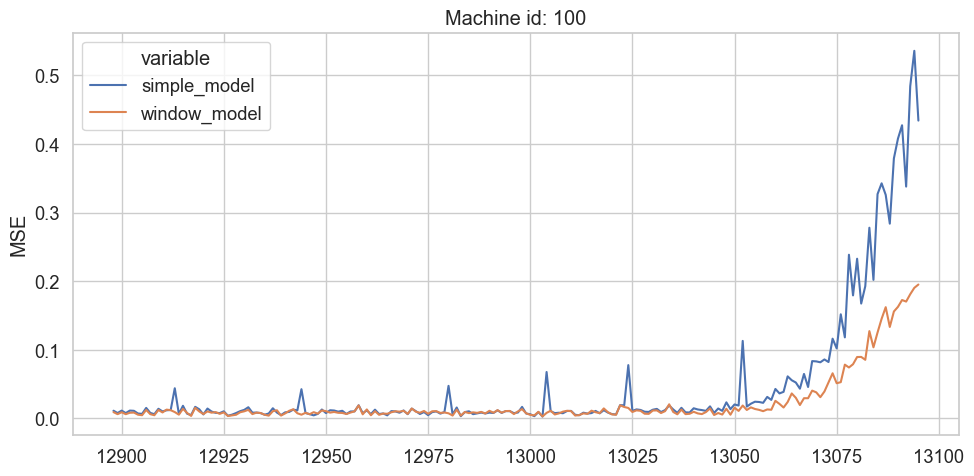

In [52]:
for machine_id in test_dataset.machine_ids.unique():
    machine_id = int(machine_id.item())
    plot_df = total_plot_df[total_plot_df['machine_id'] == machine_id].loc[:, 'simple_model':'window_model']
    plot_df = plot_df.melt(ignore_index=False)

    save_path = '../Plots/comparison_simple_window/'
    check_path(save_path)

    make_plot(plot_df, machine_id, save_path=os.path.join(save_path, f'{machine_id}.png'))